# Projeto SuperComputação 2023.2

## Análise de Redes Sociais: encontrando a clique máxima em um grafo.

Aluna : Letícia Coêlho Barbosa

<img alt= "grafo" src = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/1200px-VR_complex.svg.png" width = "600px">

### 0. **Configuração**

In [1]:
# Remove possível repositório já existente
%cd "../.."
! rm -rf Find-MaximumClique-Graph

/


In [2]:
# Clonando repositorio com as implementações:
!git clone https://github.com/leticiacb1/Find-MaximumClique-Graph

Cloning into 'Find-MaximumClique-Graph'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 253 (delta 99), reused 222 (delta 70), pack-reused 0
Receiving objects: 100% (253/253), 1.62 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [3]:
# Entrando na pasta
%cd Find-MaximumClique-Graph

/Find-MaximumClique-Graph


### 1. **Inicialização**

In [4]:
# ----------------------
# ----- Parâmetros -----
# ----------------------

lista_de_vertices = [5, 25, 50, 75, 100, 125, 150]

lista_algoritimos = ["0-busca-exaustiva-local", "1-busca-exaustiva-heuristica" , "2-busca-exaustiva-global", "3-busca-exaustiva-omp"]

# Padrão de escrita fos arquivos de grafo.
init_file_name = "data/graphs/grafo-"
extension_file_name = ".txt"

nome_de_arquivos = [init_file_name + str(v) + extension_file_name  for v in lista_de_vertices]

#### 1.1 Gerando grafos

 [INFO] O pacote utils foi importado.
 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-25.txt'.



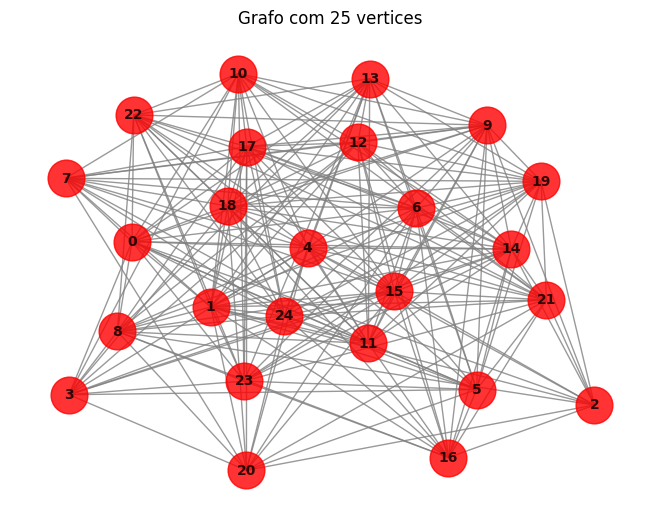

In [5]:
# --- Demonstração do uso ---

from src.python.utils.constroi_grafo import constroi_grafo

nome_arquivo = nome_de_arquivos[1]
num_vertices = lista_de_vertices[1]

save_fig_graph = "img/graphs/grafo-exemplo.png"

constroi_grafo(nome_arquivo, num_vertices, show = True, save_fig_graph = save_fig_graph)

In [6]:
# --- Gerando grafos ---

from src.python.utils.constroi_grafo import constroi_grafo

for filename , vertices in zip(nome_de_arquivos, lista_de_vertices):
  constroi_grafo(filename, vertices)

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-5.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-25.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-50.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-75.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-100.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-125.txt'.

 [INFO] Grafo densamente conectado gerado e salvo em 'data/graphs/grafo-150.txt'.



In [7]:
# Verificando se os arquivos foram mesmo criados:
%cd data/graphs
!ls

/Find-MaximumClique-Graph/data/graphs
grafo-100.txt  grafo-150.txt  grafo-50.txt  grafo-75.txt
grafo-125.txt  grafo-25.txt   grafo-5.txt   grafo.txt


In [8]:
# Voltando para pasta principal:
%cd "../.."

/Find-MaximumClique-Graph



### 2. **Abordagem Exaustiva local**


```cpp

#include<iostream>
#include<vector>
#include <fstream>
#include<algorithm>

#include "../utils/display-result.h"
#include "../utils/ler-grafo.h"

using namespace std;

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

vector<int> EncontrarCliqueMaximoLocal(vector<vector<int>> grafo, int numVertices) {
    /*
    * Calcula clique máximo local do grafo
    */

    vector<int> cliqueMaximo;
    vector<int> candidatos;

    // No inicio todos os nós são candidatos
    for (int i = 0; i < numVertices; ++i) {
        candidatos.push_back(i);
    }

    // Enquanto lista de candidados não vazia
    while(!candidatos.empty()){
        int v = candidatos.back();
        candidatos.pop_back();


        bool podeAdicionar = true;
        for (int u : cliqueMaximo) {
            if (grafo[u][v] == 0) {
                podeAdicionar = false;
                break;
            }
        }

        if (podeAdicionar) {
            cliqueMaximo.push_back(v);
            vector<int> novosCandidatos;

            for (int u : candidatos) {
                bool adjacenteATodos = true;

                for (int c : cliqueMaximo) {
                    if (grafo[u][c] == 0) {
                        adjacenteATodos = false;
                        break;
                    }
                }

                if (adjacenteATodos) {
                    novosCandidatos.push_back(u);
                }
            }

            candidatos = novosCandidatos;
        }
   }

   return cliqueMaximo;
}


// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

vector<int> main() {

    string nomeArquivo = "grafo.txt";
    int numVertices = 4;

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);
    vector<int> cliqueMaximo =  EncontrarCliqueMaximoLocal(grafo,numVertices);

    displayResult("Busca Exaustiva Local", cliqueMaximo);

    return cliqueMaximo ;
}


```

In [9]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/0-busca-exaustiva-local.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 0-busca-exaustiva-local

In [10]:
!./0-busca-exaustiva-local data/graphs/grafo-25.txt 25

 ===== [Busca Exaustiva Local] ===== 

 > Clique Máxima encontrada : 25, 23, 20, 19, 16, 15, 14, 12
 > Tamanho : 8

### 3. **Abordagem busca exaustiva local com heuristica**

Podemos definir o grau de adjacencia de um grafo simples como:

> O grau de um vértice , com o grafo representado em uma matriz de adjacencia, é dado pela soma dos elementos de sua linha (ou coluna) correspondente. [1]

ou, similarmente, também pode ser definido como:

> O grau de um vértice v em um grafo G também pode
ser visto como a quantidade de arestas incidentes em
v. [2]

Para facilitar o entendimento desse conceito, observe o grafo abaixo apresentado:

<div align="center">
  <img alt="Exemplo de calculo de grau do nó" src="https://github.com/leticiacb1/Find-MaximumClique-Graph/blob/main/img/utils/calcula_grau_exemplo.png?raw=true" />
</div>

Temos que o grau dos vertices é dado pela quantidade de arestas ligadas a ele (no caso de um grafo não direcional, não faz diferença se essas arestas são de entrada ou de saída):

$$d(v1) = 2$$

$$d(v2) = 1$$

$$d(v3) = 3$$

$$d(v4) = 2$$

$$d(v5) = 0$$


É possível inferir que a estratégia de ordenar os vertices de acordo com o seu grau de adjacencia seja uma estratégia eficaz para melhorar o desempenho do algorítimo. Isso se deve ao fato de que os vértices com maiores graus de adjacência tendem a ter uma maior probabilidade de pertencer a clique máxima, visto que em um clique, todos os vértices estão concetados entre si.


[1] https://www.ibilce.unesp.br/Home/Departamentos/MatematicaAplicada/socorro4029/representa_grafos2.pdf

[2] https://www.facom.ufms.br/~fhvm/disciplinas/anteriores/2005/grafos/aula2.pdf

`Pseudo-Código`

Utilizando como base o pseudocódigo inicialmente fornecido (`Busca Exaustiva Local`), podemos pensar nas seguintes implemnetações para a ordenação pelo calculo de adjacência:

```cpp

Função calculaGrau(grafo, vertice):
    grau = 0
    
    para cada vizinho em grafo[nó]:
        se existe_aresta(vertice, vizinho):
            grau +=1
    retornar grau

Função OrdenarPorGrau(grafo, vertice1, vertice2):
    retorna calculaGrau(grafo, vertice2) - calculaGrau(grafo, vertice1)

Função EncontrarCliqueMaximaOrdenada(grafo, numVertices):
    cliqueMaxima = ListaVazia()
    candidatos = ListaDeNós()

    Para cada i de 0 até numVertices - 1 Faça
        Adicione i à lista de candidatos

    // Ordena lista de candidatos usando a função OrdenaPorGrau
    sort(candidatos, OrdenarPorGrau);

    Enquanto candidatos não estiver vazia Faça
        v = Último elemento de candidatos
        Remova o último elemento de candidatos

        podeAdicionar = Verdadeiro

        Para cada u em cliqueMaxima Faça
            Se grafo[u][v] == 0 Então
                podeAdicionar = Falso
                Pare o loop
            Fim Se
        Fim Para

        Se podeAdicionar
            Adicione v a cliqueMaxima
            novosCandidatos = ListaDeNós()

            Para cada u em candidatos Faça
                adjacenteATodos = Verdadeiro

                Para cada c em cliqueMaxima Faça
                    Se grafo[u][c] == 0 Então
                        adjacenteATodos = Falso
                        Pare o loop
                    Fim Se
                Fim Para

                Se adjacenteATodos
                    Adicione u a novosCandidatos
                Fim Se
            Fim Para

            // Ordena novos candidatos por grau
            sort(novosCandidatos, OrdenarPorGrau);

            candidatos = novosCandidatos
        Fim Se
    Fim Enquanto

    Retorne cliqueMaxima
Fim Função

```

In [11]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/1-busca-exaustiva-heuristica.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 1-busca-exaustiva-heuristica

In [12]:
!./1-busca-exaustiva-heuristica data/graphs/grafo-25.txt 25

 ===== [Busca Exaustiva Local com Heuristica] ===== 

 > Clique Máxima encontrada : 5, 17, 8, 14, 24, 2
 > Tamanho : 6

### 4. **Abordagem Exaustiva global**

```cpp
#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string& nomeArquivo, int& numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char* argv[]) {

    if(argc != 3 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    // ------ Lê Grafo ------
    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    display_result("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}

```


In [13]:
!g++ -Wall -O3 -g \
    src/implementations/algorithm/2-busca-exaustiva-global.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 2-busca-exaustiva-global

In [14]:
!./2-busca-exaustiva-global data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : 5, 4, 2
 > Tamanho : 3

### 5. **Abordagem Exautiva global com OMP**

```cpp
#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <omp.h>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string& nomeArquivo, int& numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    #pragma omp parallel for
    for (int i = 0; i < numArestas; ++i) {
        int u, v;

        #pragma omp critical
        {
          arquivo >> u >> v;
        }

        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    bool ehClique = true;

    #pragma omp parallel for shared(ehClique) collapse(2)
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                #pragma omp critical
                {
                  ehClique = false;
                }
            }
        }
    }

    return ehClique;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;

    #pragma omp parallel for
    for (int u : candidatos) {

        if (grafo[v][u] == 1) {
            #pragma omp critical
            {
              novosCandidatos.push_back(u);
            }
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char* argv[]) {

    if(argc != 3 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    // ------ Lê Grafo ------

    vector<vector<int>> grafo = LerGrafo(nomeArquivo, numVertices);

    // ------ Clique Máximo ------
    // Gera candidatos inicias (todos os vertices)

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    // ------ Mostra na tela ------
    display_result("Busca Exaustiva Global", cliqueMaximo);

    return 0;
}

```

In [15]:
!g++ -fopenmp  -Wall -O3 -g \
    src/implementations/algorithm/3-busca-exaustiva-omp.cpp \
    src/implementations/utils/display-result.cpp \
    src/implementations/utils/ler-grafo.cpp \
    -o 3-busca-exaustiva-omp

In [16]:
!./3-busca-exaustiva-omp data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : 5, 2, 4
 > Tamanho : 3

### 6. **Abordagem Exaustiva global com MPI**

```cpp

#include<iostream>
#include <numeric>
#include<vector>
#include <fstream>
#include<algorithm>
#include <mpi.h>

using namespace std;

// ---------------------------------------------------------------------------
// ----------------------------- LER GRAFO -----------------------------------
// ---------------------------------------------------------------------------

vector<vector<int>> LerGrafo(string &nomeArquivo, int &numVertices) {
    /*
    * Ler o grafo escrito em um arquivo .txt
    */

    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;

    vector<vector<int>> grafo(numVertices, vector<int>(numVertices, 0));

    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;  // O grafo é não direcionado
    }

    arquivo.close();
    return grafo;
}

// ---------------------------------------------------------------------------
// -------------------------- CLIQUE MÁXIMA ----------------------------------
// ---------------------------------------------------------------------------

bool Clique(vector<int>& cliqueAtual, vector<vector<int>>& grafo) {
  /*
  * Verifica se clique calculado realmente já forma um clique
  */

    int n = cliqueAtual.size();
    for (int i = 0; i < n; ++i) {
        for (int j = i+1; j < n; ++j) {
            if (grafo[cliqueAtual[i]][cliqueAtual[j]] == 0) {
                return false;
            }
        }
    }
    return true;
}

vector<int> addCandidatos(vector<vector<int>> &grafo, int &v, vector<int> &candidatos){
    /*
    * Verifica a existencia de arestas entre o vertices entre v e os demais.
    * Adiciona em umalista aqueles vertices que possuem conexão com v.
    */

    vector<int> novosCandidatos;
    for (int u : candidatos) {
        if (grafo[v][u] == 1) {
            novosCandidatos.push_back(u);
        }
    }

    return novosCandidatos;
}

void EncontrarCliqueMaximoGlobal(vector<vector<int>>& grafo, vector<int>& candidatos, vector<int>& cliqueAtual, vector<int>& cliqueMaximo) {
  /*
  * Calcula clique máximo global do grafo
  */

    if(candidatos.empty()) {
        if (cliqueAtual.size() > cliqueMaximo.size() && Clique(cliqueAtual, grafo)) {
            cliqueMaximo = cliqueAtual;
        }
    }else{
        int v = candidatos.back();
        candidatos.pop_back();

        // --- Caso o vertice v pertença a solução do clique máximo ---
        cliqueAtual.push_back(v);
        vector<int> novosCandidatos = addCandidatos(grafo, v, candidatos);
        EncontrarCliqueMaximoGlobal(grafo, novosCandidatos, cliqueAtual, cliqueMaximo);

        // --- Caso o vertice v não pertença a solução do clique máximo ---
        cliqueAtual.pop_back();
        EncontrarCliqueMaximoGlobal(grafo, candidatos, cliqueAtual, cliqueMaximo);

        candidatos.push_back(v);
    }
}

// ---------------------------------------------------------------------------
// ------------------------------- MAIN --------------------------------------
// ---------------------------------------------------------------------------

void display_result(string choose_algorithm, vector<int> cliqueMaxima){
    /*
    * Mostra resultado do algorítimo na tela
    */

    cout << " ===== [" + choose_algorithm + "] ===== \n";
    cout << "\n > Clique Máxima encontrada : [";
    for (auto &el : cliqueMaxima) {
      cout << el+1 << " ";
    }
    cout << "] \n";
    cout << "\n > Tamanho : " << cliqueMaxima.size();
}

int main(int argc, char** argv) {

    // ------ Parametros ------
   if(argc != 3 ){
      cout << " [ERROR] Qunatidade errada de argumentos. Esperado = 3 argumentos | Recebeu = " << argc << " argumentos \n";
      return 1;
    }

    string nomeArquivo = argv[1];
    int numVertices = stoi(argv[2]);

    vector<vector<int>> grafo;
    vector<int> cliqueMaximoGlobal, cliqueMaximoParcial;


    // ------ Instancia MPI ------

    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);


    if(rank == 0 ){
      // ------ Processo Pai ------
      // ------ Lê Grafo ------
      grafo = LerGrafo(nomeArquivo, numVertices);

      // --- Compartilha o número de vertices com os processos ---
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // --- Envia parte do grafo para os processos ---

      for (int i = 0; i < numVertices; ++i) {
        MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }

    }else{
      // ------ Processos filhos ------
      // Recebe número de vértices

      // Outros processos recebem o número de vértices
      MPI_Bcast(&numVertices, 1, MPI_INT, 0, MPI_COMM_WORLD);

      // Alocar espaço para receber a parte do grafo
      grafo.resize(numVertices, vector<int>(numVertices, 0));

      // Receber a parte do grafo do processo raiz
      for (int i = 0; i < numVertices; ++i) {
          MPI_Bcast(grafo[i].data(), numVertices, MPI_INT, 0, MPI_COMM_WORLD);
      }
    }

    // ------------ Executado por todos ------------
    // Gera candidatos inicias (todos os vertices)
    vector<int> cliqueAtual;
    vector<int> cliqueMaximo;

    vector<int> candidatosInicias(numVertices);
    iota(candidatosInicias.begin(), candidatosInicias.end(), 0);

    EncontrarCliqueMaximoGlobal(grafo, candidatosInicias, cliqueAtual, cliqueMaximo);

    if(rank != 0){
      // Envia resultados parciais obtidos com aquela porção do grafo:
      MPI_Send(cliqueMaximo.data(), numVertices, MPI_INT, 0, 0, MPI_COMM_WORLD);

    }else{
      // Atualiza partialCliqueMaximo com tamanho do número de vertices:
      vector<int> partialCliqueMaximo(numVertices, 0);

      for (int i = 1; i < size; ++i) {
        MPI_Recv(partialCliqueMaximo.data(), numVertices, MPI_INT, i, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);

        // Atualizar clique máximo global se necessário
        if (partialCliqueMaximo.size() > cliqueMaximo.size() && Clique(partialCliqueMaximo, grafo)) {
            cliqueMaximo = partialCliqueMaximo;
        }
      }

      // ------ Mostra na tela ------
      display_result("Busca Exaustiva Global", cliqueMaximo);
    }

    MPI_Finalize();
    return 0;
}

```

In [17]:
!mpic++ -o 4-busca-exaustiva-mpi src/implementations/algorithm/4-busca-exaustiva-mpi.cpp \
                                 src/implementations/utils/display-result.cpp\
                                 src/implementations/utils/ler-grafo.cpp

In [18]:
!mpirun --allow-run-as-root -np 1 ./4-busca-exaustiva-mpi data/graphs/grafo-5.txt 5

 ===== [Busca Exaustiva Global] ===== 

 > Clique Máxima encontrada : 5, 4, 2
 > Tamanho : 3

#### 6.1 **Arquivo de configuração para o Cluster**

```bash
#!/bin/bash  
#SBATCH --job-name=4-busca-exaustiva-mpi
#SBATCH --nodes=2
#SBATCH --tasks=4     

mpirun -np 4 ./4-busca-exaustiva-mpi
```

### 7. **Resultado Esperado**

In [19]:
# Comparando resultado obtido via biblioteca do python:

from src.python.utils.clique_maximo_resposta import clique_maximo_resposta

nome_arquivo = "/Find-MaximumClique-Graph/data/graphs/grafo-5.txt"
clique_maximo_resposta(nome_arquivo, debug = True)

 ===== [ RESPOSTAS ] ===== 

 > Cliques maximais encontradas:
['1', '5']
['1', '3']
['4', '2', '3']
['4', '2', '5']

 > Clique máxima encontrada: ['4', '2', '3']

 > Clique máxima tamanho: 3


['4', '2', '3']

###8. **Verificando desempenho dos Algoritimos**

In [20]:
#   ---------------------------------
#   ---- Monta lista de comandos ----
#   ---------------------------------

#   Para executar o arquivo:
#   > ./executavel grafo.txt num_vetices

dic_comandos = {}

for algoritimo in lista_algoritimos:
  aux = []
  for v , grafo in zip(lista_de_vertices , nome_de_arquivos):
    aux.append([f"./{algoritimo}" , f"{grafo}",  f"{v}"])

  dic_comandos[algoritimo] = aux

dic_comandos

{'0-busca-exaustiva-local': [['./0-busca-exaustiva-local',
   'data/graphs/grafo-5.txt',
   '5'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-25.txt', '25'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-50.txt', '50'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-75.txt', '75'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-100.txt', '100'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-125.txt', '125'],
  ['./0-busca-exaustiva-local', 'data/graphs/grafo-150.txt', '150']],
 '1-busca-exaustiva-heuristica': [['./1-busca-exaustiva-heuristica',
   'data/graphs/grafo-5.txt',
   '5'],
  ['./1-busca-exaustiva-heuristica', 'data/graphs/grafo-25.txt', '25'],
  ['./1-busca-exaustiva-heuristica', 'data/graphs/grafo-50.txt', '50'],
  ['./1-busca-exaustiva-heuristica', 'data/graphs/grafo-75.txt', '75'],
  ['./1-busca-exaustiva-heuristica', 'data/graphs/grafo-100.txt', '100'],
  ['./1-busca-exaustiva-heuristica', 'data/graphs/grafo-125.txt', '125'],
  ['./1-busca-exausti

#### 8.1 **Comparando Busca Exaustiva Local com Busca Exaustiva Heurística**

In [22]:
#   ---------------------------------------
#   -------- Busca Exaustiva Local --------
#   ---------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-local.csv'
algoritimo = 'busca-exaustiva-local'
lista_commandos = dic_comandos['0-busca-exaustiva-local']

df_exaustiva_local = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_local

,Algoritimo,Vertices,Clique Esperado,Clique Calculado,Tamanho Esperado,Tamanho Calculado,Time (s),Mesmo Tamanho ?
0,busca-exaustiva-local,5,"[4, 2, 3]","[ 5, 4, 2]",3,3,0.002395,Sim
1,busca-exaustiva-local,25,"[19, 20, 14, 6, 3, 17, 24, 16, 23]","[ 25, 23, 20, 19, 16, 15, 14, 12]",9,8,0.002381,Não
2,busca-exaustiva-local,50,"[44, 40, 26, 17, 18, 10, 28, 34, 25, 47, 46]","[ 50, 49, 47, 46, 45, 42, 38, 21, 4]",11,9,0.002537,Não
3,busca-exaustiva-local,75,"[19, 65, 57, 17, 13, 59, 48, 26, 41, 50, 6, 75...","[ 75, 74, 70, 68, 64, 50, 42, 13, 10]",13,9,0.003898,Não
4,busca-exaustiva-local,100,"[83, 57, 98, 68, 36, 9, 28, 45, 48, 59, 26, 32...","[ 100, 98, 97, 87, 84, 76, 66, 62, 47,...",15,10,0.003017,Não
5,busca-exaustiva-local,125,"[113, 73, 75, 60, 107, 99, 101, 70, 112, 45, 3...","[ 125, 124, 122, 121, 117, 114, 91, 34,...",15,12,0.003566,Não
6,busca-exaustiva-local,150,"[71, 29, 12, 64, 125, 115, 101, 77, 117, 17, 7...","[ 150, 149, 148, 145, 144, 135, 128, 12...",17,13,0.005045,Não


In [23]:
#   --------------------------------------------
#   -------- Busca Exaustiva Heuristica --------
#   --------------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-heuristic.csv'
algoritimo = 'busca-exaustiva-heuristic'
lista_commandos = dic_comandos['1-busca-exaustiva-heuristica']

df_exaustiva_heuristica = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_heuristica

,Algoritimo,Vertices,Clique Esperado,Clique Calculado,Tamanho Esperado,Tamanho Calculado,Time (s),Mesmo Tamanho ?
0,busca-exaustiva-heuristic,5,"[4, 2, 3]","[ 5, 4, 2]",3,3,0.003278,Sim
1,busca-exaustiva-heuristic,25,"[19, 20, 14, 6, 3, 17, 24, 16, 23]","[ 5, 17, 8, 14, 24, 2]",9,6,0.005087,Não
2,busca-exaustiva-heuristic,50,"[44, 40, 26, 17, 18, 10, 28, 34, 25, 47, 46]","[ 19, 36, 8, 11, 12, 35, 2]",11,7,0.002691,Não
3,busca-exaustiva-heuristic,75,"[19, 65, 57, 17, 13, 59, 48, 26, 41, 50, 6, 75...","[ 42, 18, 61, 19, 66, 33, 38, 14, 40, 2]",13,10,0.007736,Não
4,busca-exaustiva-heuristic,100,"[83, 57, 98, 68, 36, 9, 28, 45, 48, 59, 26, 32...","[ 19, 37, 40, 52, 33, 45, 49, 75, 25]",15,9,0.004743,Não
5,busca-exaustiva-heuristic,125,"[113, 73, 75, 60, 107, 99, 101, 70, 112, 45, 3...","[ 91, 111, 56, 15, 24, 99, 18, 115, 1,...",15,11,0.004559,Não
6,busca-exaustiva-heuristic,150,"[71, 29, 12, 64, 125, 115, 101, 77, 117, 17, 7...","[ 84, 33, 87, 31, 72, 32, 109, 10, 139...",17,12,0.006683,Não


In [ ]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

In [ ]:
#   --------------------------------------------
#   ----------- Grafico de Speed Up ------------
#   --------------------------------------------

#### 8.2 **Comparando Busca Exaustiva Global e Busca Exaustiva com OMP**

In [ ]:
#   ----------------------------------------
#   -------- Busca Exaustiva Global --------
#   ----------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-global.csv'
algoritimo = 'busca-exaustiva-global'
lista_commandos = dic_comandos['2-busca-exaustiva-global']

df_exaustiva_global = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_global

In [ ]:
#   ----------------------------------------
#   ---------- Busca Exaustiva OMP ---------
#   ----------------------------------------
from src.python.utils.gera_estatisticas import gera_estatisticas

arquivo_csv = 'data/stats_busca-exaustiva-omp.csv'
algoritimo = 'busca-exaustiva-omp'
lista_commandos = dic_comandos['3-busca-exaustiva-omp']

df_exaustiva_omp = gera_estatisticas(algoritimo, lista_de_vertices, lista_commandos, arquivo_csv, debug = False)
df_exaustiva_omp

In [ ]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

In [ ]:
#   --------------------------------------------
#   ----------- Grafico de Speed Up ------------
#   --------------------------------------------

#### 8.3 **Desempenho mpi (Valores obtidos experimentalmente)**

#### 8.4 **Comparando todos os algorítimos**

In [ ]:
#   --------------------------------------------
#   ------ Grafico de Comparação Temporal ------
#   --------------------------------------------

In [ ]:
#   --------------------------------------------
#   ----------- Grafico de Speed Up ------------
#   --------------------------------------------